In [1]:
# https://github.com/MicrosoftDocs/pytorchfundamentals/blob/main/computer-vision-pytorch/pytorchcv.py
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

# torchinfo: https://github.com/TylerYep/torchinfo
!pip install torchinfo

--2021-07-15 18:58:11--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2021-07-15 18:58:11 (83.7 MB/s) - ‘pytorchcv.py’ saved [6371/6371]



In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


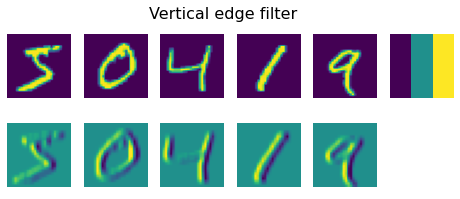

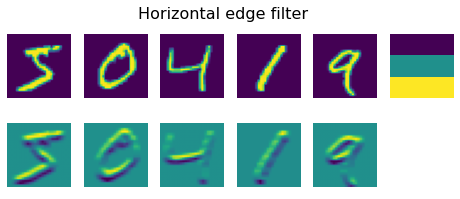

In [3]:
plot_convolution(torch.tensor([[-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.]]), "Vertical edge filter")  # vertical edge => positive or negative; horizontal edge => zero
plot_convolution(torch.tensor([[-1., -1., -1.], [0., 0., 0,], [1., 1., 1.]]), "Horizontal edge filter")

# what pytorchcv.plot_convolution does is:
# 
# def plot_convolution(t,title=''):
#     with torch.no_grad():
#         c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)  # take size([N, C, H, W]) as input
#         c.weight.copy_(t)  # c.f. clone(): Unlike copy_(), this function is recorded in the computation graph. Gradients propagating to the cloned tensor will propagate to the original tensor.
#         fig, ax = plt.subplots(2,6,figsize=(8,3))
#         fig.suptitle(title,fontsize=16)
#         for i in range(5):
#             im = data_train[i][0]  # size([1, 28, 28])
#             ax[0][i].imshow(im[0])  # size([28, 28])
#             ax[1][i].imshow(c(im.unsqueeze(0))[0][0])  # size([28, 28])
#             ax[0][i].axis('off')
#             ax[1][i].axis('off')
#         ax[0,5].imshow(t)  # size([3, 3])
#         ax[0,5].axis('off')
#         ax[1,5].axis('off')
#         #plt.tight_layout()
#         plt.show()

In [4]:
class OneConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5, 5))  # size([N,1,28,28]) --> size([N,9,24,24])  # params: 5*5*1*9 (weight) + 1*9 (bias)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184, 10)  # 5184=9*24*24
    
    def forward(self, x):
        x = nn.functional.relu(self.conv(x))  # layer with trainable weights should be defined in __init__(), so that model acknowledge the existence of those weights
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x), dim=1)  # function without trainable weights can be defined in forward() by nn.functional. But without defining it in __init__(), the torchinfo.summary() won't show it.
        return x

net = OneConv()

summary(net, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  --                        --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

Epoch  0, Train acc=0.952, Val acc=0.973, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.980, Val acc=0.978, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.985, Val acc=0.975, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.989, Val acc=0.980, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.989, Val acc=0.976, Train loss=0.000, Val loss=0.001


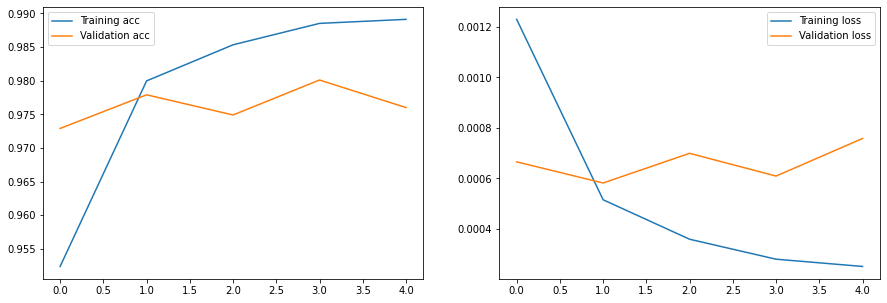

In [5]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

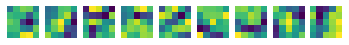

In [6]:
fig, ax = plt.subplots(1, 9)
with torch.no_grad():
    p = next(net.conv.parameters())  # first iterate: weight of conv2d, size([9, 1, 5, 5])
    for i, x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0, ...])  # x[0, :, :] => size([5, 5])
        ax[i].axis("off")

In [7]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.fc = nn.Linear(320, 10)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)  # view() has grad_fn=<ViewBackward>
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x

net = MultiLayerCNN()
summary(net, input_size=(1, 1, 28, 28))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            --                        --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

Epoch  0, Train acc=0.952, Val acc=0.979, Train loss=0.001, Val loss=0.000
Epoch  1, Train acc=0.983, Val acc=0.984, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.986, Val acc=0.987, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.987, Val acc=0.988, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.989, Val acc=0.986, Train loss=0.000, Val loss=0.000


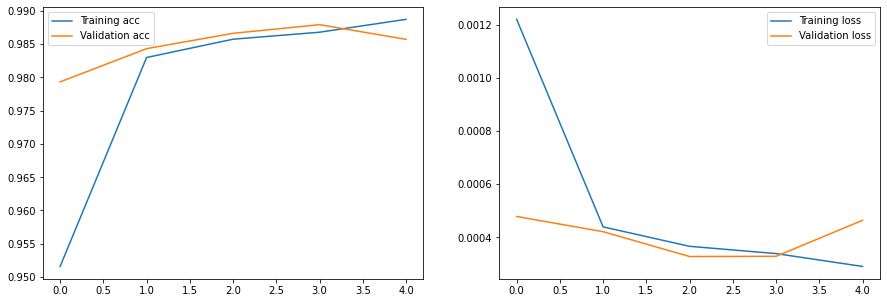

In [8]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

In [9]:
transform = torchvision.transforms.Compose(  # Composes several transforms together
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])  # normalize each "channel" of the input

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data


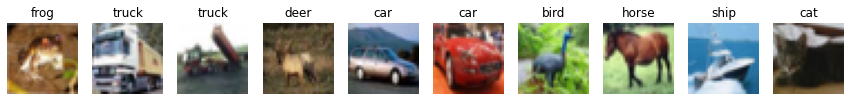

In [10]:
display_dataset(trainset, classes=classes)

# what pytorchcv.display_dataset does is:
#
# def display_dataset(dataset, n=10,classes=None):
#     fig,ax = plt.subplots(1,n,figsize=(15,3))
#     mn = min([dataset[i][0].min() for i in range(n)])
#     mx = max([dataset[i][0].max() for i in range(n)])
#     for i in range(n):
#         ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0))) # turn normalized tensor into range 0.~1. # transpose(): Reverse or permute the axes of an array
#         ax[i].axis('off')                                                                                        #              plt.imshow expects either a 2-D array with shape (x, y), and treats it like grayscale, or dimensions (x, y, 3) (treated like RGB)
#         if classes:
#             ax[i].set_title(classes[dataset[i][1]])

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)  # default stride = kernel_size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120, 64)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):  # input size([N, 3, 32, 32])
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))  # x size([N, 120, 1, 1])
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()
summary(net, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    --                        --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

Epoch  0, Train acc=0.234, Val acc=0.358, Train loss=0.149, Val loss=0.126
Epoch  1, Train acc=0.427, Val acc=0.480, Train loss=0.113, Val loss=0.102
Epoch  2, Train acc=0.502, Val acc=0.521, Train loss=0.099, Val loss=0.095


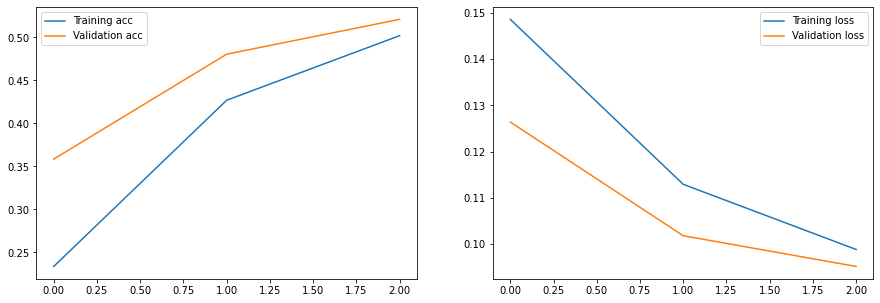

In [12]:
opt = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())
plot_results(hist)

Epoch  0, Train acc=0.243, Val acc=0.376, Train loss=0.147, Val loss=0.123
Epoch  1, Train acc=0.421, Val acc=0.467, Train loss=0.113, Val loss=0.106
Epoch  2, Train acc=0.498, Val acc=0.510, Train loss=0.099, Val loss=0.097
Epoch  3, Train acc=0.554, Val acc=0.556, Train loss=0.089, Val loss=0.088
Epoch  4, Train acc=0.593, Val acc=0.596, Train loss=0.082, Val loss=0.081
Epoch  5, Train acc=0.620, Val acc=0.611, Train loss=0.077, Val loss=0.079
Epoch  6, Train acc=0.643, Val acc=0.635, Train loss=0.072, Val loss=0.075
Epoch  7, Train acc=0.661, Val acc=0.638, Train loss=0.068, Val loss=0.075
Epoch  8, Train acc=0.681, Val acc=0.637, Train loss=0.065, Val loss=0.074
Epoch  9, Train acc=0.695, Val acc=0.648, Train loss=0.062, Val loss=0.073
Epoch 10, Train acc=0.708, Val acc=0.660, Train loss=0.059, Val loss=0.072
Epoch 11, Train acc=0.721, Val acc=0.659, Train loss=0.057, Val loss=0.073
Epoch 12, Train acc=0.732, Val acc=0.660, Train loss=0.055, Val loss=0.071
Epoch 13, Train acc=0.741

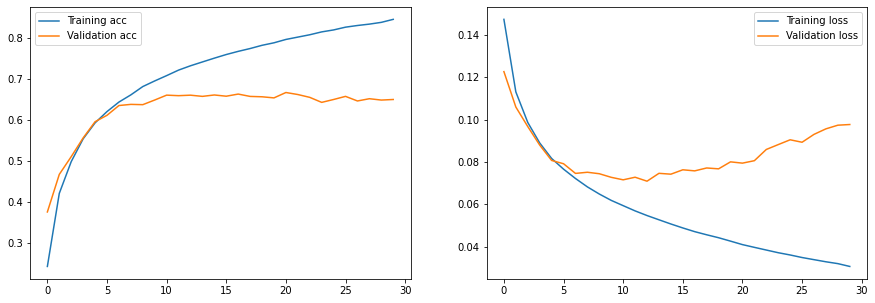

In [13]:
net = LeNet().to("cuda")  # without summary() called, need to put net to gpu
opt = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
hist = train(net, trainloader, testloader, epochs=30, optimizer=opt, loss_fn=nn.CrossEntropyLoss())
plot_results(hist)